# import 

In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:12 https://developer.download.nvidia.com/compute/c

In [ ]:
!pip install konlpy
import os
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings(action = 'ignore')
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Kkma, Okt, Mecab
import pickle
import tqdm
from gensim import models
from sklearn.metrics import accuracy_score, confusion_matrix

import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, SpatialDropout1D, Dropout, Input, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 11.7MB/s 
     |████████████████████████████████| 460kB 49.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json # import json module

# with statement
with open('/content/drive/My Drive/abstractive/train.jsonl','r', encoding =  'UTF-8') as json_file:
    files = list(json_file)

train = []
for file in files:
    train.append(json.loads(file))

In [ ]:
import json 

# with statement
with open('/content/drive/My Drive/abstractive/abstractive_test_v2.jsonl','r', encoding =  'UTF-8') as json_file:
    files = list(json_file)

test = []
for file in files:
    test.append(json.loads(file))

In [ ]:
article = []
idx = []
answer = []
for i in range(len(train)):
    article.append(train[i]['article_original'])
    idx.append(train[i]['id'])
    answer.append(train[i]['abstractive'])

In [ ]:
df = pd.DataFrame({'id':idx, 'article' : article, 'answer': answer})

In [ ]:
df['art'] = " "
for i in range(len(df)):
    temp_str = ""
    for j in range(len(df['article'][i])):
        temp_str  = temp_str + df['article'][i][j] + " "
        
    df['art'][i] = temp_str
    
df = df.drop(['article'], axis = 1)

In [ ]:
df.head()

,id,answer,art
0,327827480,지난 6일 당진시의회 행정사무감사에서 '합창단이 소리를 작게 낼 것이니 알고 있으라...,당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것으...
1,339840364,LA 에인절스의 최지만이 맹활약을 하여 시즌 타율 0.250에서 0.313으로 올리...,미국 메이저리그(MLB)에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있다...
2,371071597,16일 부평구와 협회 등에 따르면 부영공원 안에 있는 야구장을 구생활체육야구협회가 ...,인천 부영공원 운영 생활야구협회 80여 동호회 팀에 260만 원씩 받아 국유지로 임...
3,354806783,대구·경북첨단의료산업진흥재단 의약생산센터는 약사법 시행규칙에서 정한 바에 따라 전용...,대구·경북첨단의료산업진흥재단 의약생산센터는 항암주사제 무균충전 시설을 갖추고 있다....
4,347022773,식품의약품안전처는 29일 어린이가 즐겨마시는 음료를 대상으로 영양성분을 조사한 결과...,국내 유통되는 탄산음료 중 식품의약품안전처에 품질인증을 받은 제품이 하나도 없는 것...


In [ ]:
def preprocess_sentence(sentence, remove_stopwords = True):

    tokenizer = Mecab()

    stop_words = ['을', '를', '이', '가', '은', '는', 'null']
    sentence = re.sub('[^가-힣a-z0-9.]', ' ', sentence)
    token = tokenizer.morphs(sentence)

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in token if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in token if len(word) > 1)
    return tokens

In [ ]:
clean_text = []
for s in tqdm.tqdm(df['art']):
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

100%|██████████| 42803/42803 [03:16<00:00, 217.69it/s]


['당진시 문화 관광 대상 으로 행정 사무 감사 에서 당진 시립 합창단 관계자 보낸 으로 추정 문자 관련 당진시 의회 행정 사무 조사 특별 위원회 구성 조사 다고 밝혔 당진시 의회 행정 사무 감사 차였 지난 문화 관광 대상 으로 에서 최창용 의원 당진 시립 합창단 정기 연주회 앞두 문자 메세지 제보 음향 보낸 으로 추정 해당 문자 합창단 소리 으라 내용 이어 공연 에서 소리 낸다는 합창단 으로서 임무 다는 공연 자체 무력 당진시 망신 려는 행위 라며 해당 문자 보낸 단원 연루 사람 사실 관계 확인 징계 책임 물어야 한다고 지적 문제 문자 메세지 전달 문화 관광 감사 법무 담당관 에게 조사 의뢰 권경선 문화 관광 과장 누가 어떻 해서 해당 문자 나온 인지 정확히 조사 봐야 전달 문자 내용 의원 언급 부분 중간 내용 가지 전체 유추 없다 전했 하지만 감사 법무 담당관 에서 아직 조사 이뤄지지 당진시 사태 심각 인지 못하 다는 지적 동안 행정 사무 감사 진행 사태 지켜 다던 감사 법무 담당관 에서 관계 사람 조사 사태 파악 해야 는데 아직 조사 대한 뚜렷 계획 한편 지난 12 당진시 의회 에서 당진 시립 합창단 문제 비롯 구체 조사 필요 부분 대해 행정 사무 조사 특별 위원회 구성 운영 다고 밝혔 김기재 의장 본회 의결 의원 발의 으면 행정 사무 조사 특별 위원회 구성 다음 위원 상의 위원회 구성 한다면 당진 시립 합창단 관련 사안 비롯 사회 복지 기관 수탁 대해 다룰 계획 라고',
 '미국 메이저 리그 에서 활동 한국 선수 시즌 초반 희비 엇갈리 에인절스 최지만 맹활약 으로 주전 입지 굳혀 반면 텍사스 레인저스 추신수 개막전 선발 에서 밀려나 수모 당한 에서 좀처럼 못하 최지만 한국 시간 미국 플로리다주 세인트피터즈버그 트로피카나 필드 에서 열린 2019 미국 프로야구 메이저 리그 콜로 라도 로키스 홈경기 타자 루수 선발 출전 타수 안타 득점 올렸 시즌 타율 250 에서 313 16 타수 안타 올랐 최지만 개막전 에서 타수 무안타 침묵 했으나 이후 경기 연속 안타

In [ ]:
# Summary 열 전처리
clean_summary = []
for s in tqdm.tqdm(df['answer']):
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

100%|██████████| 42803/42803 [01:04<00:00, 662.74it/s]


['지난 당진시 의회 행정 사무 감사 에서 합창단 소리 으라 라는 문자 으로 불거진 합창단 의무 불이행 논란 대해 행정 사무 조사 특별 위원회 구성 조사 수행 다는 의견 표명',
 '에인절스 최지만 맹활약 시즌 타율 250 에서 313 으로 올리 주전 입지 굳혀 반면 텍사스 레인저스 추신수 개막전 선발 에서 밀려나 못하 모습 보이 미국 메이저 리그 에서 활동 한국 선수 시즌 초반 희비 엇갈리',
 '16 부평구 협회 따르 부영 공원 야구장 생활 체육 야구 협회 무상 사용 면서 이곳 이용 야구 동호회 로부터 연간 260 회비 지만 일부 리그 회원 결산 내역 야구팀 감독 에게 공개 회비 산정 기준 사용 내역 투명 공개 다고 지적',
 '대구 경북 첨단 의료 산업 진흥 재단 의약 생산 센터 약사법 시행 규칙 에서 정한 따라 전용 분리 생산 시설 에서 생산 돼야 세포독성 항암 주사제 품질 관리 기준 인증 획득 국내 에서 연구 개발 세포독성 항암 의약품 시험 생산',
 '식품 품안 전처 29 어린이 즐겨 마시 음료 대상 으로 영양 성분 조사 결과 조사 대상 632 품질 인증 제품 혼합 음료 11 탄산 음료 다고 밝혔으며 열량 저영 식품 43 확인 음료수 섭취 위해 영양 성분 안전 품질 인증 제품 선택 당부']

# 전처리 결과를 다시 df에 저장

In [ ]:
df['Text'] = clean_text
df['Summary'] = clean_summary

In [ ]:
df.replace('', np.nan, inplace=True)
print(df.isnull().sum())

id         0
answer     0
art        0
Text       0
Summary    0
dtype: int64


텍스트의 최소 길이 : 91
텍스트의 최대 길이 : 515
텍스트의 평균 길이 : 224.37287106043968
요약의 최소 길이 : 2
요약의 최대 길이 : 126
요약의 평균 길이 : 28.691026329930146


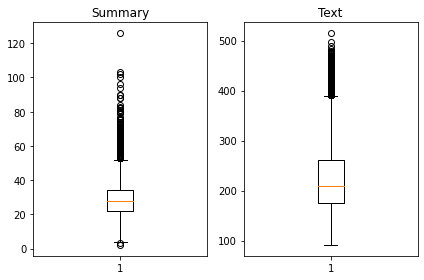

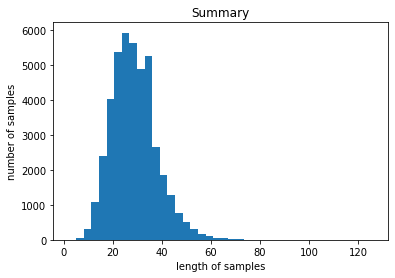

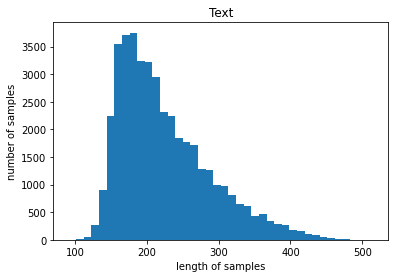

In [ ]:
# 길이 분포 출력
text_len = [len(s.split()) for s in df['Text']]
summary_len = [len(s.split()) for s in df['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 패딩 최대 길이 설정

In [ ]:
text_max_len = 350
summary_max_len = 45

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, df['Text'])
below_threshold_len(summary_max_len, df['Summary'])

전체 샘플 중 길이가 350 이하인 샘플의 비율: 0.9488119991589374
전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.952807046235077


#### Summary 열은 길이가 40 이하인 경우가 96%입니다. 정해준 최대 길이보다 큰 샘플들은 제거

In [ ]:
df = df[df['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
df = df[df['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(df)))

전체 샘플수 : 38714


#####요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.


In [ ]:
df['decoder_input'] = df['Summary'].apply(lambda x : 'sostoken '+ x)
df['decoder_target'] = df['Summary'].apply(lambda x : x + ' eostoken')
df.head()

,id,answer,art,Text,Summary,decoder_input,decoder_target
0,327827480,지난 6일 당진시의회 행정사무감사에서 '합창단이 소리를 작게 낼 것이니 알고 있으라...,당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것으...,당진시 문화 관광 대상 으로 행정 사무 감사 에서 당진 시립 합창단 관계자 보낸 으...,지난 당진시 의회 행정 사무 감사 에서 합창단 소리 으라 라는 문자 으로 불거진 합...,sostoken 지난 당진시 의회 행정 사무 감사 에서 합창단 소리 으라 라는 문자...,지난 당진시 의회 행정 사무 감사 에서 합창단 소리 으라 라는 문자 으로 불거진 합...
1,339840364,LA 에인절스의 최지만이 맹활약을 하여 시즌 타율 0.250에서 0.313으로 올리...,미국 메이저리그(MLB)에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있다...,미국 메이저 리그 에서 활동 한국 선수 시즌 초반 희비 엇갈리 에인절스 최지만 맹활...,에인절스 최지만 맹활약 시즌 타율 250 에서 313 으로 올리 주전 입지 굳혀 반...,sostoken 에인절스 최지만 맹활약 시즌 타율 250 에서 313 으로 올리 주...,에인절스 최지만 맹활약 시즌 타율 250 에서 313 으로 올리 주전 입지 굳혀 반...
2,371071597,16일 부평구와 협회 등에 따르면 부영공원 안에 있는 야구장을 구생활체육야구협회가 ...,인천 부영공원 운영 생활야구협회 80여 동호회 팀에 260만 원씩 받아 국유지로 임...,인천 부영 공원 운영 생활 야구 협회 80 동호회 260 국유지 임대료 지원 일부 ...,16 부평구 협회 따르 부영 공원 야구장 생활 체육 야구 협회 무상 사용 면서 이곳...,sostoken 16 부평구 협회 따르 부영 공원 야구장 생활 체육 야구 협회 무상...,16 부평구 협회 따르 부영 공원 야구장 생활 체육 야구 협회 무상 사용 면서 이곳...
3,354806783,대구·경북첨단의료산업진흥재단 의약생산센터는 약사법 시행규칙에서 정한 바에 따라 전용...,대구·경북첨단의료산업진흥재단 의약생산센터는 항암주사제 무균충전 시설을 갖추고 있다....,대구 경북 첨단 의료 산업 진흥 재단 의약 생산 센터 항암 주사제 무균 충전 시설 ...,대구 경북 첨단 의료 산업 진흥 재단 의약 생산 센터 약사법 시행 규칙 에서 정한 ...,sostoken 대구 경북 첨단 의료 산업 진흥 재단 의약 생산 센터 약사법 시행 ...,대구 경북 첨단 의료 산업 진흥 재단 의약 생산 센터 약사법 시행 규칙 에서 정한 ...
4,347022773,식품의약품안전처는 29일 어린이가 즐겨마시는 음료를 대상으로 영양성분을 조사한 결과...,국내 유통되는 탄산음료 중 식품의약품안전처에 품질인증을 받은 제품이 하나도 없는 것...,국내 유통 탄산 음료 식품 품안 전처 품질 인증 제품 하나 으로 나타났 혼합 음료 ...,식품 품안 전처 29 어린이 즐겨 마시 음료 대상 으로 영양 성분 조사 결과 조사 ...,sostoken 식품 품안 전처 29 어린이 즐겨 마시 음료 대상 으로 영양 성분 ...,식품 품안 전처 29 어린이 즐겨 마시 음료 대상 으로 영양 성분 조사 결과 조사 ...


###### 인코더의 입력, 디코더의 입력과 레이블을 각각 저장

In [ ]:
encoder_input = np.array(df['Text'])
decoder_input = np.array(df['decoder_input'])
decoder_target = np.array(df['decoder_target'])

# 데이터 분리

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('검증 데이터의 수 :',n_of_val)

검증 데이터의 수 : 7742


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('검증 데이터의 개수 :',len(encoder_input_test))
print('검증 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 30972
훈련 레이블의 개수 : 30972
검증 데이터의 개수 : 7742
검증 레이블의 개수 : 7742


# vecrotization

In [ ]:
#단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여, src_tokenizer.word_index에 저장
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [ ]:
threshold =6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 105834
등장 빈도가 5번 이하인 희귀 단어의 수: 67008
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 38826
단어 집합에서 희귀 단어의 비율: 63.31424683938999
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9677116233718337


In [ ]:
src_vocab = 38826
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [ ]:
print(encoder_input_train[:3])

[[9786, 15607, 135, 6989, 2, 4998, 10854, 1999, 1363, 16, 389, 9786, 60, 694, 1757, 750, 20, 60, 1757, 750, 1678, 8703, 2262, 2235, 5374, 9786, 89, 401, 389, 6989, 4248, 1419, 2881, 60, 2, 414, 1550, 1, 7731, 806, 9786, 6221, 512, 977, 867, 79, 2446, 33138, 5623, 7536, 4027, 1694, 204, 33138, 3638, 9786, 4739, 8249, 7732, 5587, 4471, 2278, 5624, 9561, 4971, 414, 1550, 5375, 9786, 4027, 1694, 1286, 16678, 1101, 9786, 176, 645, 14, 1912, 6221, 4442, 5588, 561, 29328, 3147, 304, 1758, 2, 5588, 18958, 12070, 1346, 14, 9271, 1, 1723, 29328, 3147, 2551, 926, 565, 15946, 9786, 14, 285, 10343, 1, 29329, 280, 9786, 304, 10343, 15946, 1364, 357, 414, 389, 2570, 259, 1550, 9786, 389, 50, 214, 60, 2, 414, 177, 450, 60, 2, 414, 177, 1645, 169, 414, 926, 9786, 16, 389, 10855, 3992, 951, 5, 9786, 10855, 3992, 429, 222, 389, 450, 2, 177, 79, 9786, 7426, 22353, 7030, 645, 37, 2945, 5, 16290, 9351, 1144, 8910, 1799, 692, 2773, 15608, 977, 51, 91, 14122, 1912, 450, 26471, 1419, 512, 977, 60, 694, 951, 39

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 2
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 41121
등장 빈도가 1번 이하인 희귀 단어의 수: 17237
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23884
단어 집합에서 희귀 단어의 비율: 41.91775491841152
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9486766702579508


In [ ]:
tar_vocab = 23884
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [ ]:
print(decoder_input_train[:5])

[[1, 292, 362, 55, 475, 3108, 1454, 1770, 9207, 15, 232, 362, 6726, 3158, 1006, 2126, 55, 5396, 446, 968, 1144, 66, 2865, 7958, 462, 1514, 1770, 10062, 910], [1, 10063, 2400, 407, 11, 3826, 712, 5210, 2510, 6, 745, 20, 184, 64, 392, 802, 597, 191, 184, 384, 3, 1058], [1, 23, 86, 49, 116, 507, 6, 216, 155, 8551, 4, 4339, 60, 767, 1375, 6396, 665, 7083, 641, 116, 507, 155, 215, 19, 243, 888], [1, 3730, 4745, 1099, 969, 1730, 181, 5211, 5841, 300, 3912, 98, 5841, 17757, 14542, 3730, 8552, 288], [1, 1235, 1403, 9, 1235, 5603, 241, 29, 4, 375, 4884, 202, 1833, 2024, 455, 25, 88, 57, 4470, 266, 52, 1731, 40, 292, 88, 547, 2127, 807, 373, 4, 508, 388, 2866, 385, 3731, 508, 2360, 1201, 580, 442, 2401, 25, 4, 17, 18]]


In [ ]:
print(decoder_target_train[:5])

[[292, 362, 55, 475, 3108, 1454, 1770, 9207, 15, 232, 362, 6726, 3158, 1006, 2126, 55, 5396, 446, 968, 1144, 66, 2865, 7958, 462, 1514, 1770, 10062, 910, 2], [10063, 2400, 407, 11, 3826, 712, 5210, 2510, 6, 745, 20, 184, 64, 392, 802, 597, 191, 184, 384, 3, 1058, 2], [23, 86, 49, 116, 507, 6, 216, 155, 8551, 4, 4339, 60, 767, 1375, 6396, 665, 7083, 641, 116, 507, 155, 215, 19, 243, 888, 2], [3730, 4745, 1099, 969, 1730, 181, 5211, 5841, 300, 3912, 98, 5841, 17757, 14542, 3730, 8552, 288, 2], [1235, 1403, 9, 1235, 5603, 241, 29, 4, 375, 4884, 202, 1833, 2024, 455, 25, 88, 57, 4470, 266, 52, 1731, 40, 292, 88, 547, 2127, 807, 373, 4, 508, 388, 2866, 385, 3731, 508, 2360, 1201, 580, 442, 2401, 25, 4, 17, 18, 2]]


In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [ ]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


## Padding

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## word2vec 적용

In [ ]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format("/content/drive/My Drive/abstractive/GoogleNews-vectors-negative300.bin", binary=True)
print(word2vec.vectors.shape)

(3000000, 300)


In [ ]:
print(word2vec.vectors.shape)

(3000000, 300)


In [ ]:
SRC_VOCAB_SIZE = len(src_tokenizer.index_word) + 1
EMBEDDING_DIM = 300

src_embedding_matrix = np.zeros((SRC_VOCAB_SIZE, EMBEDDING_DIM))

# tokenizer에 있는 단어 사전을 순회하면서 word2vec의 300차원 vector를 가져옵니다
for word, idx in src_tokenizer.word_index.items():
    embedding_vector = word2vec[word] if word in word2vec else None
    if embedding_vector is not None:
        src_embedding_matrix[idx] = embedding_vector
        
src_embedding_matrix.shape
# (74066, 300)

(105717, 300)

In [ ]:
TAR_VOCAB_SIZE = len(tar_tokenizer.index_word) + 1
EMBEDDING_DIM = 300

tar_embedding_matrix = np.zeros((TAR_VOCAB_SIZE, EMBEDDING_DIM))

# tokenizer에 있는 단어 사전을 순회하면서 word2vec의 300차원 vector를 가져옵니다
for word, idx in tar_tokenizer.word_index.items():
    embedding_vector = word2vec[word] if word in word2vec else None
    if embedding_vector is not None:
        tar_embedding_matrix[idx] = embedding_vector
        
tar_embedding_matrix.shape

(41264, 300)

# KoBert

In [ ]:
!pip install keras-bert

  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none-any.whl size=34145 sha256=078e900a1a054e028fd18491fe5495db0121644e6d0dec8daced55a3d5fd81f2
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for keras-transformer: filename=keras_transformer-0.38.0-cp36-none-any.whl size=12942 sha256=c5e76a624b7e14853b7019f2e4fd55f05a26063e20089ce5ba76dbf56cb3f994
  Stored in directory: /root/.cache/pip/wheels/e5/fb/3a/37b2b9326c799aa010ae46a04ddb04f320d8c77c0b7e837f4e
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=f8b19e4d09398db7b1914921d271c75f03a37f77997da4f226aad17afda7afbf
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.27.0-cp36-none-any.whl size=15612 sha256=e130a22cd24f820ae214fd6fdd2299c023f34218d882ad58cd820fe993b60b88
  Stor

In [ ]:
from keras_bert import get_pretrained, PretrainedList, get_checkpoint_paths, load_trained_model_from_checkpoint, extract_embeddings

In [ ]:
model_path = get_pretrained(PretrainedList.multi_cased_base)
paths = get_checkpoint_paths(model_path)
print(paths.config, paths.checkpoint, paths.vocab)

662904832/662903077 [==============================] - 4s 0us/step
/root/.keras/datasets/multi_cased_L-12_H-768_A-12/bert_config.json /root/.keras/datasets/multi_cased_L-12_H-768_A-12/bert_model.ckpt /root/.keras/datasets/multi_cased_L-12_H-768_A-12/vocab.txt


In [ ]:
model = load_trained_model_from_checkpoint(
    config_file = paths.config,
    checkpoint_file = paths.checkpoint,
    trainable=True,
    training=True,
    seq_len=len(encoder_input_train)
)

# Transformer

In [1]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights



class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]


def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  

def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)


def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  

def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, activation = 'softmax', name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

small_transformer = transformer(
    vocab_size = 38826,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.1,
    name="small_transformer")

NameError: ignored

In [ ]:
small_transformer.summary()

# seq2seq + attention

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 300
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(SRC_VOCAB_SIZE, embedding_dim, weights=[src_embedding_matrix], trainable=False)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(TAR_VOCAB_SIZE, embedding_dim, weights=[tar_embedding_matrix], trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.2, recurrent_dropout=0.1)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [ ]:
import urllib

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 350, 300)     31849500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 350, 256), ( 570368      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [ ]:
small_transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 8)
history = small_transformer.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 32, callbacks=[es], epochs = 50)

Epoch 1/50
968/968 [==============================] - 131s 136ms/step - loss: 4.3633 - val_loss: 4.1029
Epoch 2/50
968/968 [==============================] - 128s 132ms/step - loss: 4.0657 - val_loss: 3.9582
Epoch 3/50
968/968 [==============================] - 128s 132ms/step - loss: 3.8739 - val_loss: 3.8785
Epoch 4/50
968/968 [==============================] - 128s 133ms/step - loss: 3.7227 - val_loss: 3.8349
Epoch 5/50
968/968 [==============================] - 129s 133ms/step - loss: 3.5932 - val_loss: 3.8160
Epoch 6/50
968/968 [==============================] - 129s 134ms/step - loss: 3.4822 - val_loss: 3.8080
Epoch 7/50
968/968 [==============================] - 128s 132ms/step - loss: 3.3842 - val_loss: 3.8047
Epoch 8/50
968/968 [==============================] - 128s 133ms/step - loss: 3.2986 - val_loss: 3.8047
Epoch 9/50
968/968 [==============================] - 127s 131ms/step - loss: 3.2216 - val_loss: 3.8228
Epoch 10/50
703/968 [====================>.........] - ETA: 32s 

KeyboardInterrupt: ignored

# 요약 모델 테스트

##### 테스트를 위한 사전

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [ ]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  지현기 송현동 배수지 신설 안동시가 송현동 신설해 20일부터 자연 통한 수돗물 공급에 들어간다 안동시가 원을 투입 송현동 해발 지점에 신설해 20일부터 자연 통한 수돗물 공급에 들어간다 일부 고지대 지역은 그동안 지대가 낮은 펌프 왔으나 어렵고 고장 나면 많은 세대에 단수 사고가 우려됐던 실정이었다 안동시는 지난 2015년 착공 4 6 매설하고 배수지 가압장 1개소를 설치 완료했다 이로써 그동안 지형적인 여건으로 수돗물 공급이 원활하지 못했던 보다 안정적인 수돗물 공급이 가능하게 됐다 안동시 사업 완료로 기존 가압장 5개소 송현 송현 청구 송현 방송국 주변 폐쇄하고 신설한 송현동 통해 안정적인 공급하는 만큼 주거지역 확대에 따른 증가에 대처할 있을 것으로 기대된다 말했다 이와 함께 앞으로 지역과 수량 부족 지역을 중심으로 단계적으로 상수도 시설을 확충해 시민들에게 안정적으로 양질의 수돗물 공급할 계획 이라고 밝혔다 
실제 요약문 : 안동시가 자연 통한 수돗물 공급을 위해 30억 투입하고 신설해 그동안 수돗물 공급이 지원할 예정이다 
예측 요약문 :  지난 27일 열린 대회의실에서 열린 전남 최초로 열린 전남 최초로 지역 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 기업 지원 등을 대한 등을


원문 :  자료 세종시청 제공 세종시가 대전도시철도 1호선을 연장해 대전과 세종을 잇는 대전 추진한다고 밝혔다 이춘희 시장은 18일 브리핑을 통해 이춘희 세종시장은 18일 갖고 대전도시철도 1호선을 14 연결하고 구간에 건설하는 사업을 추진할 계획이라고 밝혔다 세종시는 지난해 5월부터 광역철도 연결을 위한 타당성 진행했다 사업추진을 좌우하는 비용 대비 0 95로 고려할 비교적 높은 수준이라는 세종시의 평가다 1일 평균 2040년 기준 소요시간은 16분 내외가 것으로 예상됐다 총사업비는 1조 대도시권광역교통위원회 심의를 거쳐 광역철도로 지정 경우 국가 70 지자체 30 비율로 사업비를

KeyboardInterrupt: ignored

In [ ]:
from konlpy.tag import Mecab